In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import quantstats as qs
qs.extend_pandas()

## Settings

In [74]:
# Settings
local_data = [True, False][1]
all_local = [True, False][1]
max_sharpe = [True, False][0]
min_variance = [True, False][0]
target_vol = [True, False][0]
manual_weights  = [True, False][1]
plot_timeseries = [True, False][0]
l2_reg = [True, False][0]
semi_var = [True, False][0]
c_VAR = [True, False][0]
stock = "BZ=F ZN=F GC=F SI=F IYR LQD EEM ^N225 ^N100" #"BZ=F NQ=F ZN=F GC=F SI=F ZT=F ZB=F ES=F IYR EWJ LQD EEM ^N225 ^N100"
fund_folder = r'\fund_series'
prefix_name = 'yhoo_asset_classes'
train_start = '2000-01-01'
train_end = '2010-12-31'
test_start = '2011-01-01'
test_end = date.today()


# Mean-variance optimization

In [36]:
def generate_performance_metrics (prices_pivot = None, prefix_name = None, file_text = None, benchmark = 'SPY', title = 'Strategy Tearsheet', weights = None):
    returns = np.log(prices_pivot/prices_pivot.shift(1))
    agg_returns = returns * weights
    portfolio_return = agg_returns.sum(axis=1)
    portfolio_return.name = 'Close'
    portfolio_return.index = pd.to_datetime(portfolio_return.index)
    qs.reports.html(returns = portfolio_return, benchmark = benchmark, output = prefix_name + file_text + '.html', title= prefix_name+ title)

## Downloading data

In [37]:
import yfinance as yf
from datetime import date
today = date.today()

[*********************100%***********************]  9 of 9 completed


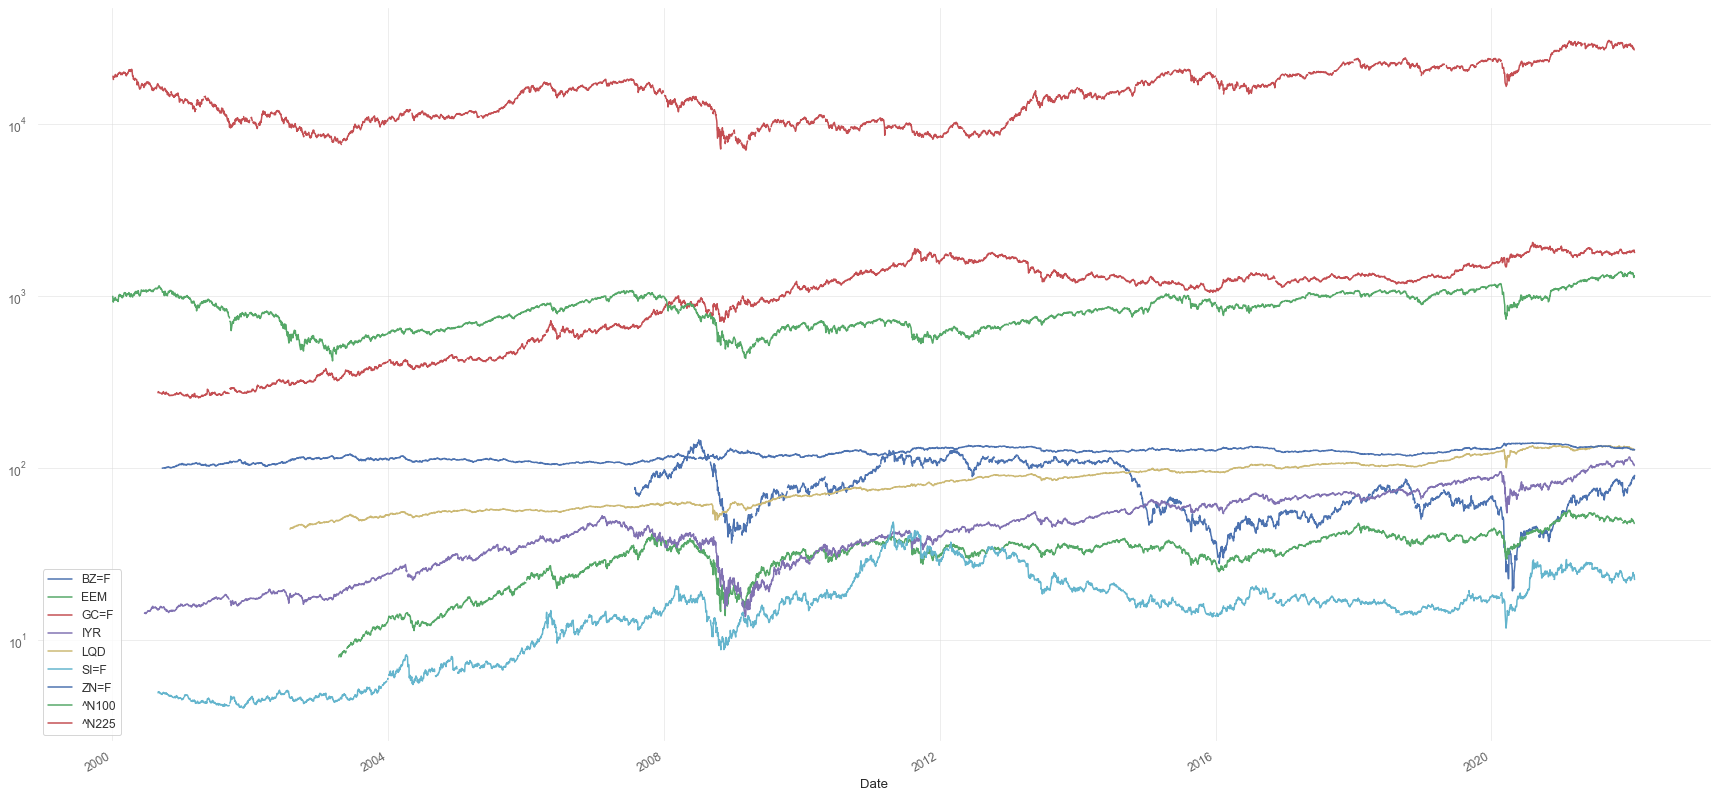

In [38]:
if local_data == False:
    date_start = '2000-01-01'
    date_end = today.strftime("%Y-%m-%d")
    time_interval = ['daily', 'weekly','monthly'][0]
    data = yf.download(stock, start=date_start, end=date_end)
    data_close = data['Adj Close']
    concatenated_df_pivot = data_close
    concatenated_df_pivot = concatenated_df_pivot.sort_values(by="Date", key=pd.to_datetime)
    concatenated_df_pivot = concatenated_df_pivot.dropna()
    if plot_timeseries:
        data_close.plot(logy= True, figsize=(30,15))



In [39]:
# ALL FILES
path = r'C:\Users\Ferhat\Python Code\Github\Portfolio_Optimisation\PortfolioOptimisation' + fund_folder                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
iterator = zip(np.arange(len(all_files)).tolist(), all_files)
file_list = dict(iterator)
file_list


{0: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Allianz Technology Trust Ord daily.csv',
 1: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Fundsmith Equity I Inc daily.csv',
 2: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\GS India Equity R Inc GBP daily.csv',
 3: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\HgCapital Trust Ord daily.csv',
 4: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares Physical Gold ETC GBP.csv',
 5: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares Physical Silver ETC GBP.csv',
 6: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares £ Corp Bond 0-5yr ETF GBP Dist.csv',


In [40]:
# SOME FILES
if local_data:
    indices = [14, 3, 8, 9, 13, 12]
    sub_files = []

    for index in indices:
        sub_files.append(file_list[index])

    df_from_each_file = (pd.read_csv(f, index_col=False) for f in sub_files)
    concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
    
    for x in range(len(sub_files)):
        print(sub_files[x])
    concatenated_df.drop([ 'High', 'Low', 'Open', 'Volume'], axis=1, inplace=True)
    concatenated_df['Close'] = concatenated_df['Close'].fillna(concatenated_df['NAV'])
    concatenated_df.drop(['NAV'], axis=1, inplace=True)
    concatenated_df_pivot = concatenated_df.pivot(columns='Name', values='Close', index='Date')
    concatenated_df_pivot = concatenated_df_pivot.sort_values(by="Date", key=pd.to_datetime)
    concatenated_df_pivot = concatenated_df_pivot.dropna()

    if plot_timeseries:
        concatenated_df_pivot.plot(figsize=(15,10))

In [75]:
concatenated_df_pivot

,BZ=F,EEM,GC=F,IYR,LQD,SI=F,ZN=F,^N100,^N225
Date,,,,,,,,,
2007-07-30,75.739998,33.469345,664.099976,40.587322,59.062553,12.834000,107.218750,1001.500000,17289.300781
2007-07-31,77.050003,32.784325,666.900024,40.046932,59.033993,12.950000,107.421875,1019.929993,17248.890625
2007-08-01,75.349998,32.655724,663.599976,40.672672,59.224682,12.888000,107.453125,1002.150024,16870.980469
2007-08-02,75.760002,33.016785,664.599976,41.269955,59.144257,12.935000,107.468750,1006.469971,16984.109375
2007-08-03,74.750000,31.592335,672.500000,39.751125,59.437263,13.100000,107.875000,992.890015,16979.859375
...,...,...,...,...,...,...,...,...,...
2022-01-21,87.889999,49.000000,1831.800049,105.370003,128.899994,24.313999,128.312500,1335.089966,27522.259766
2022-01-24,86.269997,48.310001,1841.699951,105.540001,128.500000,23.795000,128.515625,1282.859985,27588.369141
2022-01-25,88.199997,48.220001,1852.699951,105.059998,128.139999,23.896000,128.125000,1287.709961,27131.339844


## Split the data

In [77]:
train_df = concatenated_df_pivot.loc[train_start:train_end]
train_df

,BZ=F,EEM,GC=F,IYR,LQD,SI=F,ZN=F,^N100,^N225
Date,,,,,,,,,
2007-07-30,75.739998,33.469345,664.099976,40.587322,59.062553,12.834000,107.218750,1001.500000,17289.300781
2007-07-31,77.050003,32.784325,666.900024,40.046932,59.033993,12.950000,107.421875,1019.929993,17248.890625
2007-08-01,75.349998,32.655724,663.599976,40.672672,59.224682,12.888000,107.453125,1002.150024,16870.980469
2007-08-02,75.760002,33.016785,664.599976,41.269955,59.144257,12.935000,107.468750,1006.469971,16984.109375
2007-08-03,74.750000,31.592335,672.500000,39.751125,59.437263,13.100000,107.875000,992.890015,16979.859375
...,...,...,...,...,...,...,...,...,...
2010-12-22,93.650002,37.088352,1386.800049,37.391682,74.434731,29.367001,120.000000,708.270020,10346.480469
2010-12-27,93.849998,36.929371,1382.400024,37.574509,74.613388,29.235001,119.937500,699.880005,10355.990234
2010-12-28,94.379997,36.961170,1405.199951,37.723473,74.018776,30.297001,119.031250,699.659973,10292.629883


## Calculating the covariance matrix

In [41]:
import pypfopt
pypfopt.__version__

'1.5.1'

In [42]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(concatenated_df_pivot, frequency=252)
sample_cov

,BZ=F,EEM,GC=F,IYR,LQD,SI=F,ZN=F,^N100,^N225
BZ=F,0.162839,0.045008,0.013439,0.025551,0.001839,0.038729,-0.005569,0.031806,0.016025
EEM,0.045008,0.093746,0.006471,0.066009,0.004641,0.025982,-0.006326,0.042281,0.020033
GC=F,0.013439,0.006471,0.035280,0.001286,0.002294,0.051117,0.002210,-0.000098,-0.000925
IYR,0.025551,0.066009,0.001286,0.099004,0.003783,0.013191,-0.004173,0.030586,0.009332
LQD,0.001839,0.004641,0.002294,0.003783,0.008801,0.004667,0.002055,0.003260,0.002382
SI=F,0.038729,0.025982,0.051117,0.013191,0.004667,0.117476,0.000806,0.014767,0.010388
ZN=F,-0.005569,-0.006326,0.002210,-0.004173,0.002055,0.000806,0.003886,-0.004927,-0.002230
^N100,0.031806,0.042281,-0.000098,0.030586,0.003260,0.014767,-0.004927,0.048945,0.023188
^N225,0.016025,0.020033,-0.000925,0.009332,0.002382,0.010388,-0.002230,0.023188,0.061555


<AxesSubplot:>

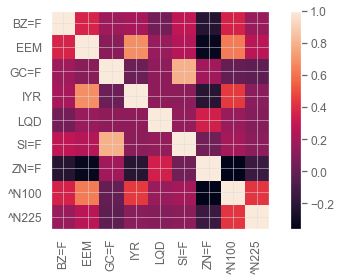

In [43]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

## Return estimation

In [44]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(concatenated_df_pivot)
mu

BZ=F     0.106072
EEM      0.097765
GC=F     0.049001
IYR      0.083855
LQD      0.028805
SI=F     0.092354
ZN=F     0.016274
^N100    0.069557
^N225    0.056487
Name: mkt, dtype: float64

## Manual Weights

In [45]:
if manual_weights:
    concatenated_df['Name'].unique()
    initial_weights = [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]
    unique_fund_names = concatenated_df['Name'].unique()

    iterator = zip(unique_fund_names.tolist(), initial_weights)
    comb_weights = dict(iterator)
    comb_weights
    generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'manual_weights', prefix_name = prefix_name, file_text = 'manual_weights', weights = comb_weights)



## Long/short min variance

In [46]:
from pypfopt import EfficientFrontier

In [47]:
S = risk_models.CovarianceShrinkage(concatenated_df_pivot).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(0, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('BZ=F', 0.01504),
             ('EEM', 0.01117),
             ('GC=F', 0.02658),
             ('IYR', 0.01705),
             ('LQD', 0.10615),
             ('SI=F', 0.0),
             ('ZN=F', 0.71275),
             ('^N100', 0.08076),
             ('^N225', 0.0305)])

In [48]:
ef.portfolio_performance(verbose=True);

Annual volatility: 5.5%


In [49]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'min_variance', prefix_name = prefix_name, file_text = 'min_variance', weights = weights)

## Max Sharpe

In [50]:
S = risk_models.CovarianceShrinkage(concatenated_df_pivot).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('BZ=F', 0.11464),
             ('EEM', 0.11482),
             ('GC=F', 0.11183),
             ('IYR', 0.11467),
             ('LQD', 0.11128),
             ('SI=F', 0.1171),
             ('ZN=F', 0.08955),
             ('^N100', 0.11207),
             ('^N225', 0.11403)])

In [51]:
ef.portfolio_performance(verbose=True);

Expected annual return: 6.8%
Annual volatility: 14.5%
Sharpe Ratio: 0.33


In [52]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_sharpe', prefix_name = prefix_name, file_text = 'max_sharpe', weights = weights)

## Maximise return for a given risk, with L2 regularisation

In [72]:
ef = EfficientFrontier(mu, S)
ef.efficient_risk(target_volatility=0.06)
weights = ef.clean_weights()
weights

OrderedDict([('BZ=F', 0.03498),
             ('EEM', 0.03146),
             ('GC=F', 0.07276),
             ('IYR', 0.03523),
             ('LQD', 0.10733),
             ('SI=F', 0.0),
             ('ZN=F', 0.5816),
             ('^N100', 0.08892),
             ('^N225', 0.04773)])

In [73]:
ef.portfolio_performance(verbose=True)

Expected annual return: 3.5%
Annual volatility: 6.0%
Sharpe Ratio: 0.25


(0.03474294794497242, 0.06000000009933018, 0.24571579867609047)

In [69]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_return_given_risk', prefix_name = prefix_name, file_text = 'max_return_given_risk', weights = weights)

## L2 Regularisation

In [56]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('BZ=F', 0.12317),
             ('EEM', 0.12344),
             ('GC=F', 0.10463),
             ('IYR', 0.11787),
             ('LQD', 0.09529),
             ('SI=F', 0.12447),
             ('ZN=F', 0.08822),
             ('^N100', 0.1127),
             ('^N225', 0.11022)])

In [57]:
ef.portfolio_performance(verbose=True)

Expected annual return: 7.0%
Annual volatility: 15.0%
Sharpe Ratio: 0.33


(0.06988457387447619, 0.15000000005028102, 0.33256382571836357)

In [58]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_return_l2_reg', prefix_name = prefix_name, file_text = 'max_return_L2_reg', weights = weights)

## Efficient semi-variance optimization

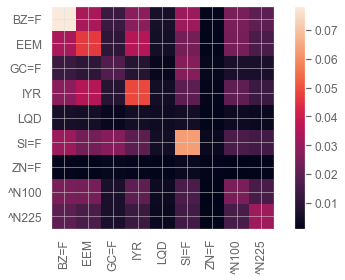

In [59]:
semicov = risk_models.semicovariance(concatenated_df_pivot, benchmark=0)
plotting.plot_covariance(semicov);

In [60]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.06)
weights = ef.clean_weights()
weights

OrderedDict([('BZ=F', 0.0688),
             ('EEM', 0.16188),
             ('GC=F', 0.12089),
             ('IYR', 0.03351),
             ('LQD', 0.38463),
             ('SI=F', 0.063),
             ('ZN=F', 0.0),
             ('^N100', 0.13734),
             ('^N225', 0.02994)])

In [61]:
ef.portfolio_performance(verbose=True);

Expected annual return: 6.0%
Annual volatility: 10.7%
Sharpe Ratio: 0.37


In [62]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'semi_var_opt', prefix_name = prefix_name, file_text = 'semi_var_opt', weights = weights)

## Efficient CVaR optimization

In [63]:
returns = expected_returns.returns_from_prices(concatenated_df_pivot).dropna()
returns.head()

,BZ=F,EEM,GC=F,IYR,LQD,SI=F,ZN=F,^N100,^N225
Date,,,,,,,,,
2007-07-31,0.017296,-0.020467,0.004216,-0.013314,-0.000484,0.009039,0.001894,0.018402,-0.002337
2007-08-01,-0.022064,-0.003923,-0.004948,0.015625,0.003230,-0.004788,0.000291,-0.017433,-0.021909
2007-08-02,0.005441,0.011057,0.001507,0.014685,-0.001358,0.003647,0.000145,0.004311,0.006706
2007-08-03,-0.013332,-0.043143,0.011887,-0.036802,0.004954,0.012756,0.003780,-0.013493,-0.000250
2007-08-06,-0.047893,0.017848,-0.001487,0.026044,-0.003480,-0.009389,-0.001883,-0.010464,-0.003852


In [64]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 6.8%
Annual volatility: 14.5%
Sharpe Ratio: 0.33


## Plotting - Unconstrained

In [65]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 3.7%
Annual volatility: 6.5%
Sharpe Ratio: 0.27


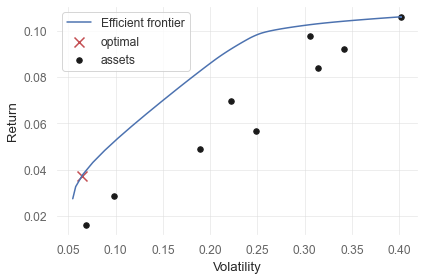

In [66]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)